<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C6/C6.html"><img src="../data/C6_nav.png" width="100"  style="float:right;" alt="C6"></a>
<h1>Onset Detection</h1> 
</div>

<br/>

<p>
Following Section 6.1 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>, we introduce in this notebook the task referred to as onset detection. An overview of onset detection methods can also be found in the following articles:

<ul>
<li><span style="color:black">
Juan Pablo Bello, Laurent Daudet, Samer A. Abdallah, Chris Duxbury, Mike E. Davies, and Mark B. Sandler: <strong>A Tutorial on Onset Detection in Music Signals.</strong> IEEE Transaction on Speech and Audio Processing 13(5-2), 2005, pp. 1035&ndash;1047.   
<br>
<a type="button" class="btn btn-default btn-xs" target="_blank" href="../data/bibtex/FMP_bibtex_BelloDADDS05_OnsetTutorial_IEEE-TSA.txt"> Bibtex </a>
</span></li>
    <li><span style="color:black">
Simon Dixon: <strong>Onset Detection Revisited.</strong> Proceedings of the International Conference on Digital Audio Effects (DAFx), 2006, pp. 133&ndash;137.
<br>
<a type="button" class="btn btn-default btn-xs" target="_blank" href="../data/bibtex/FMP_bibtex_Dixon06_OnsetDection_DAFx.txt"> Bibtex </a>
</span></li>
</ul>    
</p> 

## Musical Onsets

The notion of a musical onset can be rather vague and is related to other concepts such as attacks or transients. When playing a note on an instrument such as a piano, there is often a sudden increase of energy at the beginning of a musical tone. The **attack** of a note refers to the phase where the sound builds up, which typically goes along with a sharply increasing amplitude envelope. The related concept of a **transient** refers to a noise-like sound component of short duration and high amplitude typically occurring at the beginning of a musical tone or a more general sound event. As opposed to the attack and transient, the **onset** of a note refers to the single instant (rather than a period) that marks the beginning of the transient, or the earliest time point at which the transient can be reliably detected. This is illustrated by the following figure.

<img src="../data/C6/FMP_C6_F02b.png" width="320px" align="middle" alt="FMP_C6_F02b">

Intuitively speaking, **onset detection** is the task of determining the starting times of notes or other musical events as they occur in a music recording. To detect note onsets in the signal, the general idea is to capture sudden changes that often mark the beginning of transient regions. For notes that have a pronounced attack phase, onset candidates may be determined by locating time positions where the signal's amplitude envelope starts increasing. In the following figure, we show the waveform and the spectrogram of a click sound as well as of a piano sound (playing the note C4):

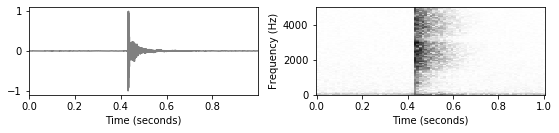

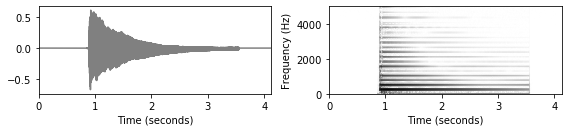

In [1]:
import os, sys
import sys
import numpy as np
from scipy import signal
from  matplotlib import pyplot as plt
import librosa
import IPython.display as ipd
import pandas as pd
sys.path.append('..')
import libfmp.b
import libfmp.c2
import libfmp.c6

%matplotlib inline

def plot_wav_spectrogram(fn_wav, xlim=None, audio=True):
    """Plot waveform and computed spectrogram and may display audio
    Notebook: C6/C6S1_OnsetDetection.ipynb
    """
    Fs = 22050
    x, Fs = librosa.load(fn_wav, Fs) 
    plt.figure(figsize=(8,2)) 
    ax = plt.subplot(1,2,1)
    libfmp.b.plot_signal(x, Fs, ax=ax)
    if xlim!=None: plt.xlim(xlim)
    ax = plt.subplot(1,2,2)
    N, H = 512, 256 
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hanning')
    Y = np.log(1 + 10 * np.abs(X))
    libfmp.b.plot_matrix(Y, Fs=Fs/H, Fs_F=N/Fs, ax=[ax], colorbar=False)
    plt.ylim([0,5000])
    if xlim is not None: plt.xlim(xlim)
    plt.tight_layout()
    plt.show()
    if audio: ipd.display(ipd.Audio(x, rate=Fs))

        
fn_wav = os.path.join('..', 'data', 'C6', 'FMP_C6_F04_Impulse.wav')
plot_wav_spectrogram(fn_wav)

fn_wav = os.path.join('..', 'data', 'C6', 'FMP_C6_F04_NoteC4_Piano.wav')
plot_wav_spectrogram(fn_wav)

When there is no clear attack phase, such as for nonpercussive music with soft onsets and blurred note transitions, the detection of onsets is much more challenging. For example, the waveform of a violin sound may exhibit a slow energy increase rather than an abrupt change as in a piano sound. For soft sounds, it is hard to determine or even to define the exact onset position. This is illustrated by the violin example (sound of C4) of the next figure:

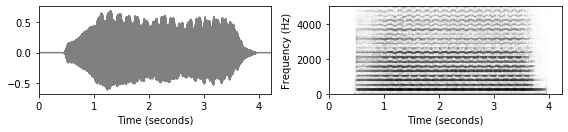

In [2]:
fn_wav = os.path.join('..', 'data', 'C6', 'FMP_C6_F04_NoteC4_Violin.wav')
plot_wav_spectrogram(fn_wav)

The detection of individual note onsets becomes even harder when dealing with complex polyphonic music. Simultaneously occurring sound events may result in masking effects, where no significant changes in the signal's energy are measurable. This is illustrated by the first measures of the third movement of Borodin's String Quartet No. 2.

<!--This is illustrated by the first measures of the Piano Quartet Op. 15 by Gabriel Fauré:-->

<img src="../data/C6/FMP_C6_Audio_Borodin-sec39_RWC_score.png" width="900px" align="left" alt="FMP_C6_Audio_Borodin">

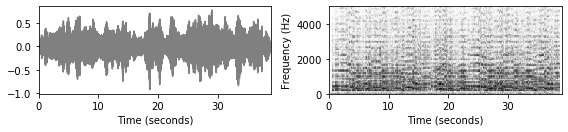

Plot of the first six seconds:


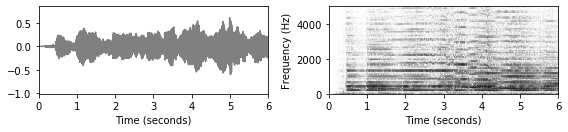

In [3]:
#fn_wav = os.path.join('..', 'data', 'C6', 'FMP_C6_Audio_Faure_Op015-01-sec0-12_SMD126.wav')
fn_wav = os.path.join('..', 'data', 'C6', 'FMP_C6_Audio_Borodin-sec39_RWC.wav')
plot_wav_spectrogram(fn_wav)
print('Plot of the first six seconds:')
plot_wav_spectrogram(fn_wav, xlim=[0,6], audio=False)

## General Pipeline

Many approaches for onset detection follow a similar algorithmic pipeline, but differ in the signal properties that are exploited to derive onset candidates. In this pipeline, the main steps are as follows:

* First, the signal is converted into a suitable feature representation that better reflects the properties of interest. 
* Then, a type of derivative operator is applied to the feature sequence and a **novelty function** is derived. 
* Finally, a peak-picking algorithm is employed to locate the onset candidates.

In particular, we show how to transform a given music signal into a **novelty representation** that captures certain changes in the signal's energy or spectrum. The peaks of such a representation yield good indicators for note onset candidates. We have seen a similar concept when applying novelty detection to music structure analysis. 

In the following notebooks, we study four different approaches for computing novelty functions:

* [Energy-based novelty](../C6/C6S1_NoveltyEnergy.html) approaches measure changes in the flow of the signal's local energy (see Section 6.1.1 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>).

* [Spectral-based novelty](../C6/C6S1_NoveltySpectral.html) approaches measure changes of the signal's spectral content over time (see Section 6.1.2 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>).

* [Phase-based novelty](../C6/C6S1_NoveltyPhase.html) approaches measure indicate discontinuities in the signal's phase spectrum, see  Section 6.1.3 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>).

* [Complex-domain novelty](../C6/C6S1_NoveltyComplex.html) approaches combine spectral-based and phase-based information, see Section 6.1.4 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>.

In the [FMP notebook on novelty comparison](../C6/C6S1_NoveltyComparison.html), all four novelty detection approaches are directly compared using different music examples.

## Example: Another One Bites the Dust
  
As an illustrative example, we consider an excerpt of "Another one bites the dust" by Queen. Starting with an offbeat consisting of two sixteenth notes played only by bass, four percussive beats (played by kick drum, snare drum, hihat, and bass) follow. Furthermore, between each two subsequent beats, there is an additional hihat stroke. The subsequent figure shows the waveform with annotated onset positions. 

<img src="../data/C6/FMP_C6_F01a.png" width="350px" align="left" alt="FMP_C6_F01.png">

<br clear="all" />

<audio style="width: 320px;" src="../data/C6/FMP_C6_F01_Queen.mp3" type="audio/mpeg" controls="controls"></audio>

The following spectrogram representation shows, that the quarter-note drum beats as well as the hihat sounds go along with transients (vertical lines), while the initial two bass-only sounds have more diffuse onset properties.

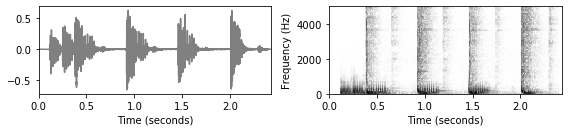

In [4]:
fn_wav = os.path.join('..', 'data', 'C6', 'FMP_C6_F01_Queen.wav')
plot_wav_spectrogram(fn_wav, audio=False)

In the next code cell, we use a [spectral-based method](../C6/C6S1_NoveltySpectral.html) for computing a novelty function. 

   position  label
0  0.117460  onset
1  0.247619  onset
2  0.372698   beat
3  0.646349  onset
4  0.911111   beat
5  1.184762  onset
6  1.445442   beat
7  1.735238  onset
8  2.000000   beat
9  2.287619  onset


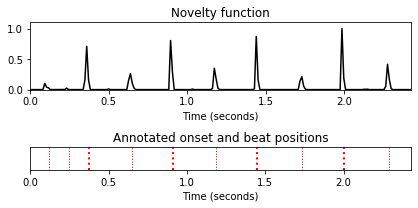

In [5]:
def read_annotation_pos(fn_ann, label='', header=True, print_table=False):
    """Read and convert file containing either list of pairs (number,label) or list of (number)

    Notebook: C6/C6S1_OnsetDetection.ipynb

    Args:
        fn_ann (str): Name of file
        label (str): Name of label (Default value = '')
        header (bool): Assumes header (True) or not (False) (Default value = True)
        print_table (bool): Prints table if True (Default value = False)

    Returns:
        ann (list): List of annotations
        label_keys (dict): Dictionaries specifying color and line style used for labels
    """
    df = libfmp.b.read_csv(fn_ann, header=header)
    if print_table:
        print(df)
    num_col = df.values[0].shape[0]
    if num_col == 1:
        df = df.assign(label=[label] * len(df.index))
    ann = df.values.tolist()

    label_keys = {'beat': {'linewidth': 2, 'linestyle': ':', 'color': 'r'},
                  'onset': {'linewidth': 1, 'linestyle': ':', 'color': 'r'}}
    return ann, label_keys

fn_ann = os.path.join('..', 'data', 'C6', 'FMP_C6_F01_Queen.csv')
ann, label_keys = read_annotation_pos(fn_ann, print_table=True)

x, Fs = librosa.load(fn_wav)
x_duration = len(x)/Fs
nov, Fs_nov = libfmp.c6.compute_novelty_spectrum(x, Fs=Fs)

fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(6, 3))
libfmp.b.plot_signal(nov, Fs_nov, ax=ax[0], color='k', title='Novelty function');
libfmp.b.plot_annotation_line(ann, ax=ax[1], label_keys=label_keys,
                    time_min=0, time_max=x_duration)
ax[1].set_title('Annotated onset and beat positions')
ax[1].set_xlabel('Time (seconds)')

plt.tight_layout()

Finally, we apply a [peak picking strategy](../C6/C6S1_PeakPicking.html) to locate the **local maxima** or **peaks** of the novelty function. The positions of the peaks are our candidates for onset positions. In the following code cell, we apply a peak picking strategy provided by the function [`scipy.signal.find_peaks`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html). Furthermore, we generate a visualization of the peaks along with a **sonification** via a click track added to the original audio recording. 

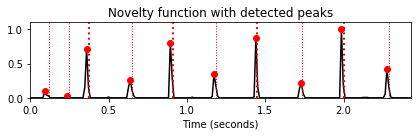

In [6]:
peaks, properties = signal.find_peaks(nov, prominence=0.02)
T_coef = np.arange(nov.shape[0]) / Fs_nov
peaks_sec = T_coef[peaks]
fig, ax, line = libfmp.b.plot_signal(nov, Fs_nov, color='k', 
                    title='Novelty function with detected peaks')
libfmp.b.plot_annotation_line(ann, ax=ax, label_keys=label_keys, 
                    nontime_axis=True, time_min=0, time_max=x_duration)
plt.plot(peaks_sec, nov[peaks], 'ro')
plt.show()

x_peaks = librosa.clicks(peaks_sec, sr=Fs, click_freq=1000, length=len(x))
ipd.display(ipd.Audio(x + x_peaks, rate=Fs))

## Further Notes

* In the subsequent notebooks, we discuss various novelty detection approaches that captures certain changes in the signal's energy or spectrum. In particular, we introduce an [energy-based novelty](../C6/C6S1_NoveltyEnergy.html), a [spectral-based novelty](../C6/C6S1_NoveltySpectral.html), a [phase-based novelty](../C6/C6S1_NoveltyPhase.html), and a [complex-domain novelty](../C6/C6S1_NoveltyComplex.html) detection approach.
* In the [FMP notebook on novelty comparison](../C6/C6S1_NoveltyComparison.html), these novelty detection approaches are directly compared.
* In the [FMP notebook on peak picking](../C6/C6S1_PeakPicking.html), one finds an overview of different implementations of peak picking strategies.

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a>.
</div> 

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>